In [74]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

hrv_middle_data_path = 'hrv-middle-data/'
measurement = 'CVSD_mean'

res = pd.DataFrame([], columns=['pcode', 'RMSSD_mean', 'CVSD_mean', 'SDNN_mean', 'RMSSD_std', 'CVSD_std', 'SDNN_std'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = hrv_middle_data_path + participant_key + '_hrv_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 5:
        print(participant_key + ' has too less data, filtered out')
        continue
    
    res.loc[len(res)] = [participant_key, df['HRV_RMSSD'].mean(), df['HRV_CVSD'].mean(), df['HRV_SDNN'].mean(), df['HRV_RMSSD'].std(), df['HRV_CVSD'].std(), df['HRV_SDNN'].std()]

res


hrv-middle-data/P01_hrv_result.csv do not exist
P04 has too less data, filtered out
P05 has too less data, filtered out
P06 has too less data, filtered out
hrv-middle-data/P07_hrv_result.csv do not exist
P08 has too less data, filtered out
P10 has too less data, filtered out
P14 has too less data, filtered out
P20 has too less data, filtered out
hrv-middle-data/P27_hrv_result.csv do not exist
P29 has too less data, filtered out
P36 has too less data, filtered out
P37 has too less data, filtered out
P40 has too less data, filtered out
P42 has too less data, filtered out
P44 has too less data, filtered out
P45 has too less data, filtered out
P48 has too less data, filtered out
P49 has too less data, filtered out
P51 has too less data, filtered out
P56 has too less data, filtered out
P58 has too less data, filtered out
hrv-middle-data/P59_hrv_result.csv do not exist
P60 has too less data, filtered out
hrv-middle-data/P65_hrv_result.csv do not exist
P69 has too less data, filtered out
P70 

,pcode,RMSSD_mean,CVSD_mean,SDNN_mean,RMSSD_std,CVSD_std,SDNN_std
0,P02,141.567618,0.192254,193.302474,30.732919,0.054704,72.572533
1,P03,132.980989,0.165972,116.549077,37.095972,0.038120,26.176967
2,P09,110.998613,0.148360,101.190951,48.415578,0.073590,40.726764
3,P11,106.226859,0.128504,101.544261,52.622318,0.069077,37.524908
4,P12,163.030045,0.187777,118.515494,90.723591,0.091608,21.339439
5,P13,125.632455,0.162011,123.000363,77.767839,0.099468,50.037831
6,P15,123.897324,0.163040,116.144312,48.174394,0.067558,36.682545
7,P16,165.761720,0.204604,163.874992,39.217124,0.062332,38.009304
8,P17,121.381211,0.180756,109.586788,67.684937,0.091832,48.058078
9,P18,62.821170,0.085802,77.846834,29.796030,0.046173,34.478112


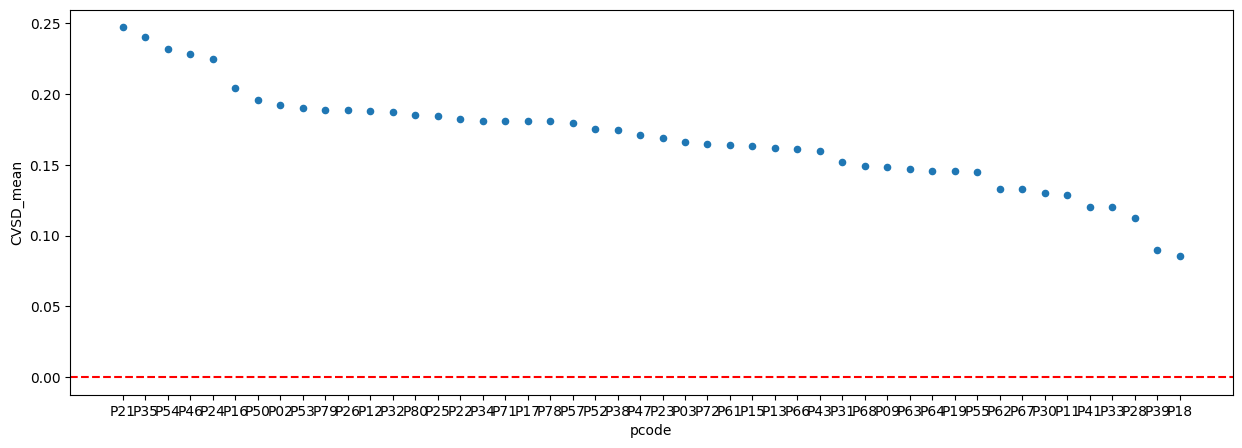

In [75]:

res.sort_values(by=measurement, ascending=False, inplace=True)
# res = res[4:64]
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))


plot.axhline(0, color='red', linestyle='--', label='y=0 line')

In [76]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


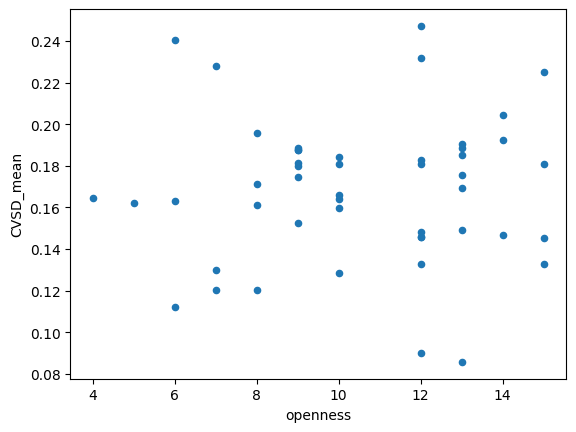

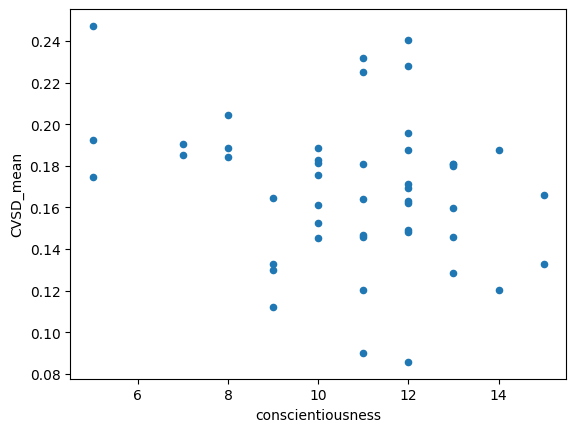

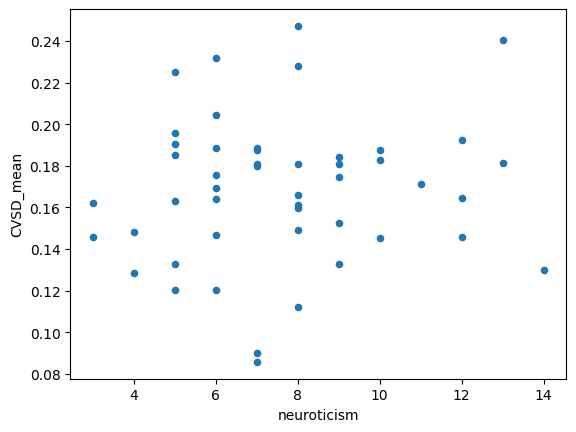

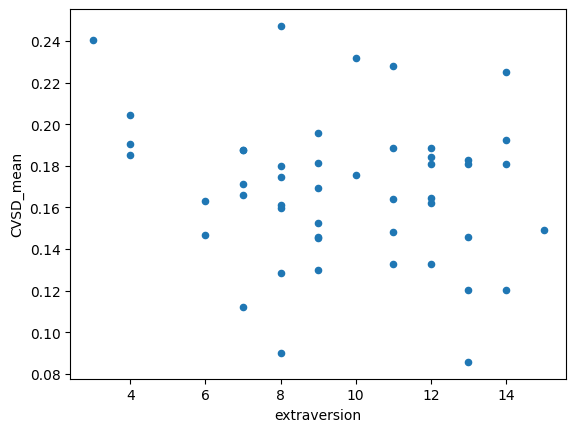

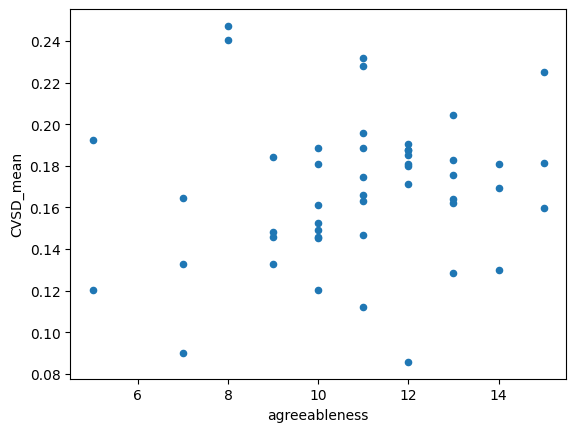

In [77]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [78]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              CVSD_mean   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.244
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.306
Time:                        16:10:25   Log-Likelihood:                 96.422
No. Observations:                  48   AIC:                            -180.8
Df Residuals:                      42   BIC:                            -169.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1791      0.04

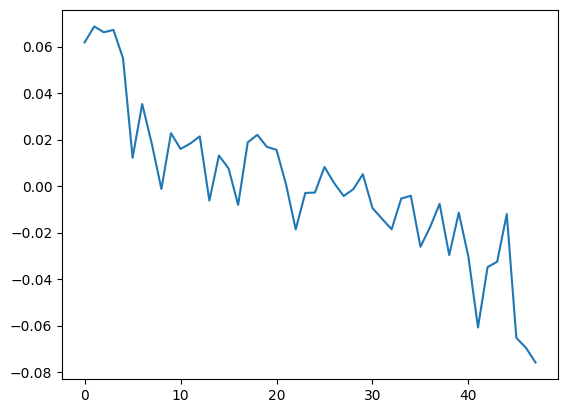

In [79]:
plot = plt.plot(results.resid)

In [80]:
scipy.stats.shapiro(results.resid)

ShapiroResult(statistic=0.9544759101294971, pvalue=0.060412306971694724)

In [81]:
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=0.03113890508008206, pvalue=0.8335890203886899)
conscientiousness PearsonRResult(statistic=-0.2585639759135939, pvalue=0.07598452753384835)
neuroticism PearsonRResult(statistic=0.10651938089436873, pvalue=0.4711625657514201)
extraversion PearsonRResult(statistic=-0.1880830173451366, pvalue=0.20047855187211494)
agreeableness PearsonRResult(statistic=0.15055281513784918, pvalue=0.3070639637841109)
